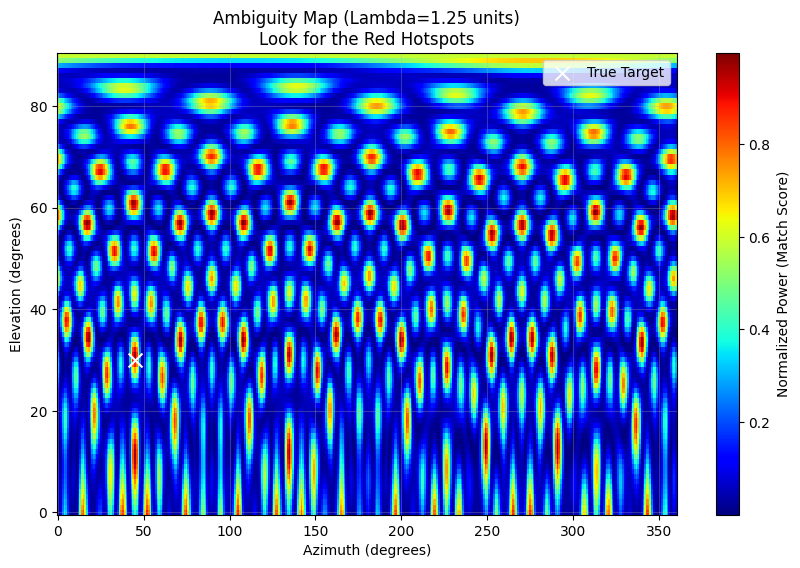

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP ---
wavelength = 1.25

# Sensor Coordinates (x, y, z)
# A: (0, 7, -2), B: (-7.2, 0, -2), C: (7.2, 0, -2), D: (0,0,0), E: (0, -7, -2)
sensors = np.array([
    [0, 7, -2],
    [-7.2, 0, -2],
    [7.2, 0, -2],
    [0, 0, 0],    # Center sensor (Reference)
    [0, -7, -2]
])

# --- 2. SIMULATE SIGNAL ---
# True direction of the target (in degrees)
true_azimuth = 45.0   # Example: 45 degrees
true_elevation = 30.0 # Example: 30 degrees up from horizon

# Convert spherical to unit vector (d_hat)
# Standard physics convention: Azimuth from X-axis, Elevation from XY-plane
az_rad = np.radians(true_azimuth)
el_rad = np.radians(true_elevation)

d_true = np.array([
    np.cos(el_rad) * np.cos(az_rad),
    np.cos(el_rad) * np.sin(az_rad),
    np.sin(el_rad)
])

# Generate Phase Measurements (The "Parallel Vector" Model)
# Phase = (2*pi/lambda) * (Position . Direction)
# We add noise to make it realistic
noise_level_degrees = 10.0 # Phase noise std dev
phases_measured = (2 * np.pi / wavelength) * (sensors @ d_true)
phases_measured += np.radians(np.random.normal(0, noise_level_degrees, 5))
# Wrap phases to -pi, pi (This simulates the real-world ambiguity)
phases_measured = np.angle(np.exp(1j * phases_measured))

# --- 3. SOLVER (Bartlett Beamformer) ---
def beamformer_scan(sensors, measured_phases, wavelength):
    # Scan Grid
    az_scan = np.linspace(0, 360, 361) # 0 to 360 degrees
    el_scan = np.linspace(0, 90, 91)   # 0 to 90 degrees (upper hemisphere)

    # Create the mesh for plotting later
    Az, El = np.meshgrid(az_scan, el_scan)

    # Pre-compute all test direction vectors
    # Shape: (3, num_el, num_az)
    Az_rad = np.radians(Az)
    El_rad = np.radians(El)

    Dx = np.cos(El_rad) * np.cos(Az_rad)
    Dy = np.cos(El_rad) * np.sin(Az_rad)
    Dz = np.sin(El_rad)

    # Flatten for matrix multiplication
    # Directions matrix D_test shape: (3, N_points)
    D_test = np.vstack([Dx.ravel(), Dy.ravel(), Dz.ravel()])

    # EXPECTED Phase for all test angles: (2*pi/lambda) * (Sensors @ D_test)
    # Result shape: (Num_Sensors, N_points)
    expected_phases = (2 * np.pi / wavelength) * (sensors @ D_test)

    # COMPLEX COMPARISON (The "Score")
    # We compare Measured phasor vs Expected phasor
    # Score = | Sum( exp(j * (Measured - Expected)) ) |^2
    # We broadcast measured_phases to match the shape
    phasor_diff = np.exp(1j * (phases_measured[:, None] - expected_phases))

    # Sum across all sensors (axis 0)
    array_response = np.abs(np.sum(phasor_diff, axis=0))**2

    # Normalize score (0 to 1)
    array_response = array_response / (len(sensors)**2)

    # Reshape back to grid for plotting
    response_grid = array_response.reshape(Az.shape)

    return Az, El, response_grid

# Run the scan
Az, El, response = beamformer_scan(sensors, phases_measured, wavelength)

# --- 4. VISUALIZE ---
plt.figure(figsize=(10, 6))
# Plot heatmap
plt.pcolormesh(Az, El, response, shading='auto', cmap='jet')
plt.colorbar(label='Normalized Power (Match Score)')
plt.scatter([true_azimuth], [true_elevation], color='white', marker='x', s=100, label='True Target')
plt.title(f'Ambiguity Map (Lambda={wavelength} units)\nLook for the Red Hotspots')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [22]:
import numpy as np
import itertools

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
WAVELENGTH = 1.25

# Sensor Positions (x, y, z)
# Reference Sensor is D at (0,0,0)
# We define the baselines relative to D
sensors = {
    'A': np.array([0, 7, -2]),
    'B': np.array([-7.2, 0, -2]),
    'C': np.array([7.2, 0, -2]),
    'E': np.array([0, -7, -2])
}

# Convert dictionary to Matrix R (4x3)
# Order: A, B, C, E
R_matrix = np.array([sensors['A'], sensors['B'], sensors['C'], sensors['E']])

# ==========================================
# 2. THE ROBUST SOLVER
# ==========================================
def solve_direction_robust(R, phases_measured, wavelength):
    """
    R: (4,3) matrix of baselines [A; B; C; E]
    phases_measured: (4,) array of phases in radians [-pi, pi]
    wavelength: scalar
    """

    # --- Step A: Determine Integer Bounds ---
    # We limit the search space based on physical length
    baseline_lengths = np.linalg.norm(R, axis=1)
    n_bounds = np.ceil(baseline_lengths / wavelength).astype(int) + 5

    # Create ranges for each sensor (e.g., -5 to 5)
    ranges = [range(-b, b+1) for b in n_bounds]

    # Pre-calculate Pseudo-Inverse for speed
    R_pinv = np.linalg.pinv(R)

    candidates = []

    # --- Step B: Brute Force Search ---
    # Loop through all combinations of integers
    for n_tuple in itertools.product(*ranges):
        n_vec = np.array(n_tuple)

        # 1. Construct the "Unwrapped" Path Difference (Hypothesis)
        # y = n * lambda + phase_fraction * lambda
        y_unwrapped = (n_vec * wavelength) + (phases_measured * wavelength / (2 * np.pi))

        # 2. Least Squares Solve for Direction Vector (Raw)
        d_raw = R_pinv @ y_unwrapped
        raw_len = np.linalg.norm(d_raw)

        # 3. FAST REJECTION (Optimization)
        # If length is wildly off (e.g. > 1.5 or < 0.5), skip expensive checks.
        if raw_len < 0.8 or raw_len > 1.2:
            continue

        # 4. Force Unit Vector
        d_unit = d_raw / raw_len

        # 5. Calculate Score (Cost Function)
        # Part A: Residual (How well does it fit the phases?)
        y_predicted = R @ d_unit
        residual_error = np.sum((y_unwrapped - y_predicted)**2)

        # Part B: Geometric Penalty (Was the raw vector length close to 1?)
        # We weigh this heavily (x1000) because physics is strict.
        geom_penalty = 1000.0 * (raw_len - 1.0)**2

        total_score = residual_error + geom_penalty

        # Save candidate
        candidates.append((total_score, d_unit, n_vec, residual_error, raw_len))

    # --- Step C: Sort and Select ---
    # Sort by lowest score
    candidates.sort(key=lambda x: x[0])

    return candidates

# ==========================================
# 3. SIMULATION & TEST
# ==========================================

# --- Create a Fake Target ---
true_az = 45.0  # degrees
true_el = 30.0  # degrees

print(f"--- SIMULATION SETUP ---")
print(f"True Target: Az={true_az}, El={true_el}")
print(f"Wavelength: {WAVELENGTH}")

# Convert to unit vector
az_rad, el_rad = np.radians(true_az), np.radians(true_el)
d_true = np.array([
    np.cos(el_rad) * np.cos(az_rad),
    np.cos(el_rad) * np.sin(az_rad),
    np.sin(el_rad)
])

# Generate ideal phases
ideal_path_diffs = R_matrix @ d_true
ideal_phases = (2 * np.pi / WAVELENGTH) * ideal_path_diffs

# Add Noise (Critical for testing robustness)
noise_deg = 1.1 # Standard deviation in degrees
print(f"Adding Noise: {noise_deg} degrees std dev")
noise_rad = np.radians(np.random.normal(0, noise_deg, 4))
measured_phases_noisy = np.angle(np.exp(1j * (ideal_phases + noise_rad)))

# --- RUN THE SOLVER ---
print("\nScanning integer combinations... (this may take a second)")
results = solve_direction_robust(R_matrix, measured_phases_noisy, WAVELENGTH)

# ==========================================
# 4. RESULTS DISPLAY
# ==========================================

print(f"\n--- TOP 3 CANDIDATES ---")
print(f"{'Score':<10} | {'Integers (n_A, n_B, n_C, n_E)':<25} | {'Azimuth':<8} | {'Elevation':<9} | {'RawLen':<6}")
print("-" * 80)

for i in range(min(3, len(results))):
    score, d_vec, n_ints, resid, raw_l = results[i]

    # Convert vector to angles
    el_deg = np.degrees(np.arcsin(d_vec[2]))
    az_deg = np.degrees(np.arctan2(d_vec[1], d_vec[0]))
    if az_deg < 0: az_deg += 360

    # Highlight the winner
    prefix = ">> " if i == 0 else "   "

    print(f"{prefix}{score:.4f} | {str(n_ints):<25} | {az_deg:.2f}°   | {el_deg:.2f}°    | {raw_l:.3f}")

if len(results) == 0:
    print("No valid solution found! (Check if data is too noisy or wavelength is wrong)")

# Sanity Check for the User
best_sol = results[0]
print(f"\nFINAL DECISION: Azimuth {np.degrees(np.arctan2(best_sol[1][1], best_sol[1][0])) % 360:.2f}°")

--- SIMULATION SETUP ---
True Target: Az=45.0, El=30.0
Wavelength: 1.25
Adding Noise: 1.1 degrees std dev

Scanning integer combinations... (this may take a second)

--- TOP 3 CANDIDATES ---
Score      | Integers (n_A, n_B, n_C, n_E) | Azimuth  | Elevation | RawLen
--------------------------------------------------------------------------------
>> 0.0000 | [ 3 -4  3 -4]             | 45.02°   | 29.98°    | 1.000
   0.0003 | [ 6  0  2 -4]             | 78.55°   | -25.98°    | 0.999
   0.0009 | [ 2 -5  6 -1]             | 14.91°   | -7.20°    | 1.001

FINAL DECISION: Azimuth 45.02°
